In [8]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/spectral/io/envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Sample cube: (2080, 640, 214) | Bands: 214


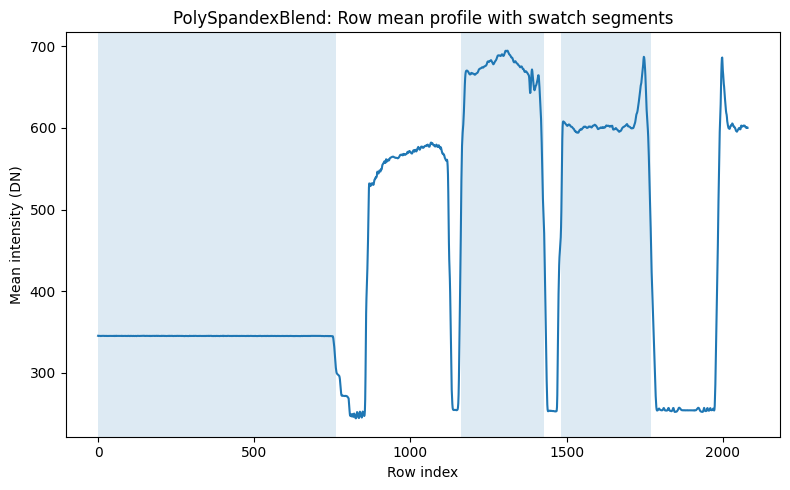

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/polyspandexblend_seg_profile.png


/tmp/ipython-input-732092883.py:87: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


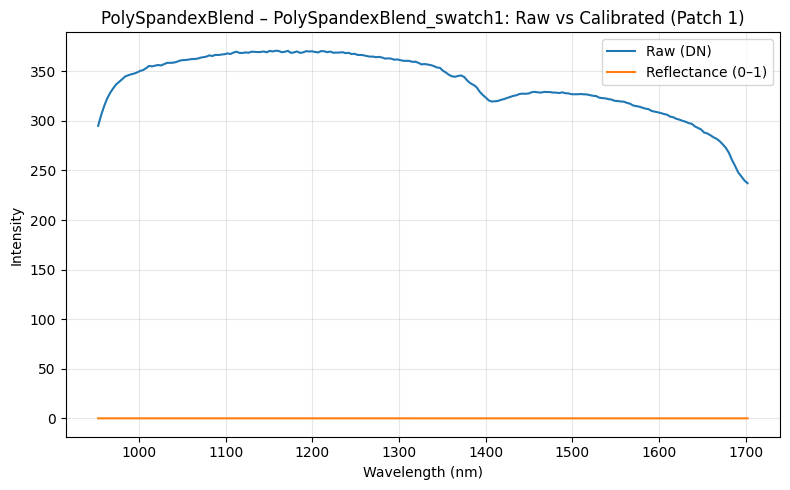

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch1_raw_vs_reflectance.png


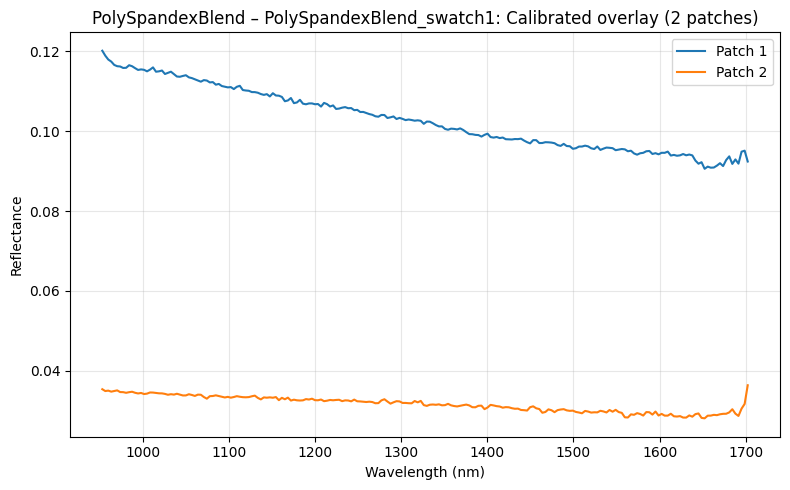

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch1_reflectance_overlay_patches.png


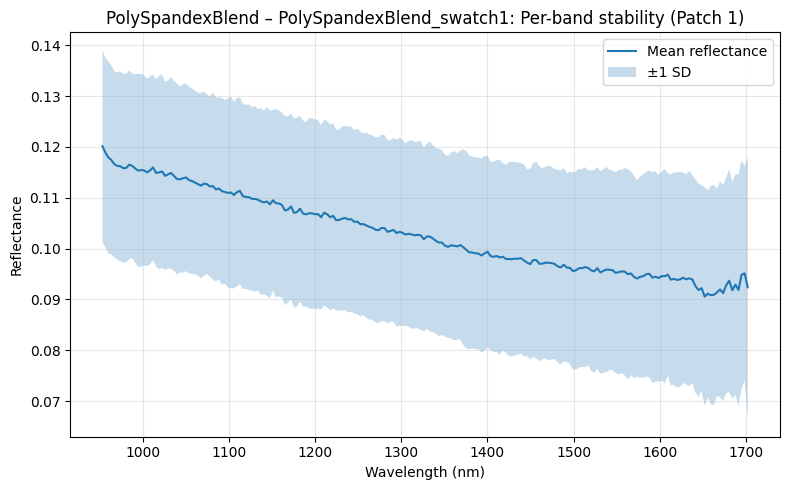

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch1_stability_mean_sd.png


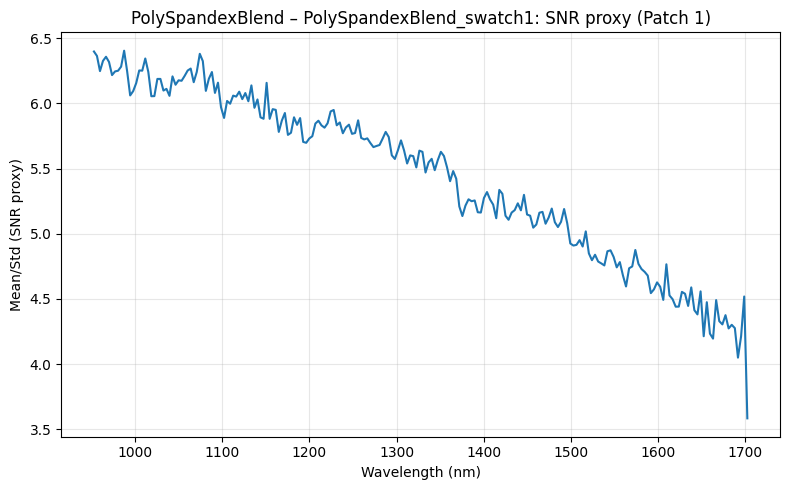

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch1_snr_proxy.png
Saved CSV: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch1_patch_spectra.csv


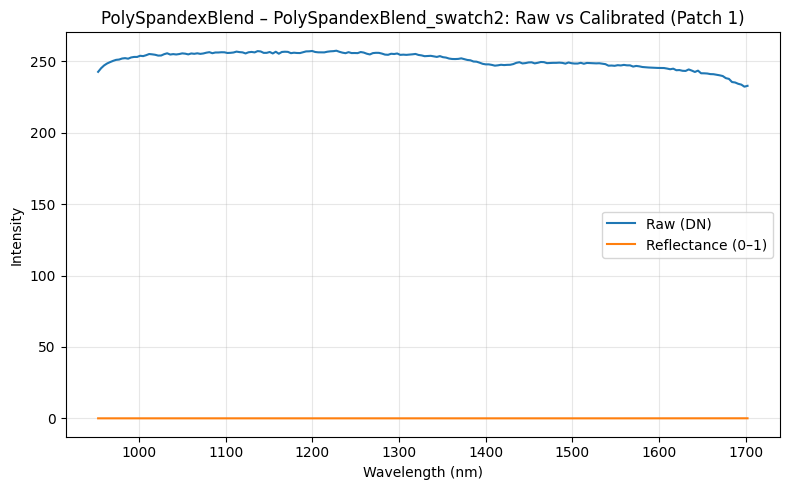

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch2_raw_vs_reflectance.png


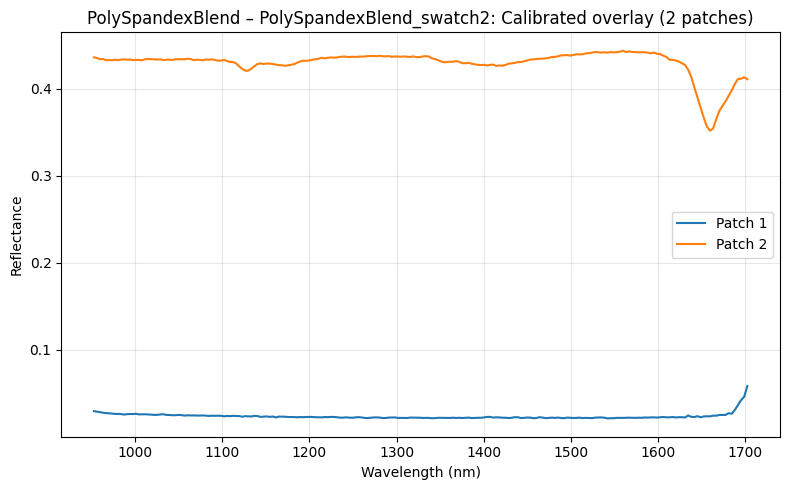

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch2_reflectance_overlay_patches.png


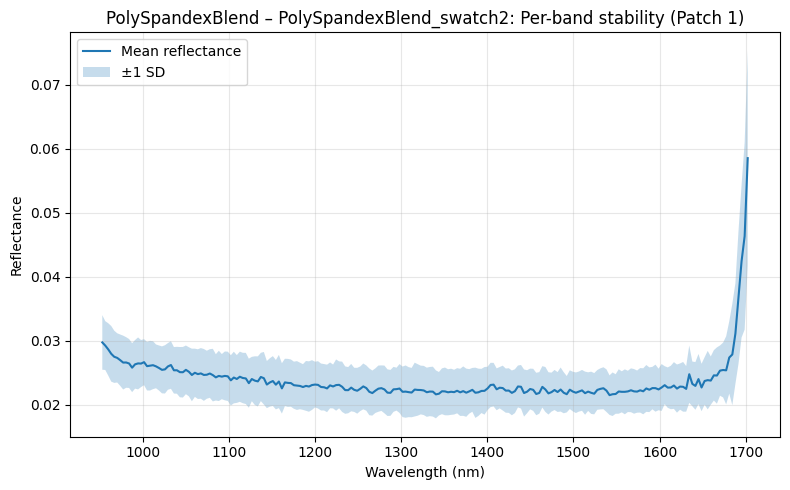

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch2_stability_mean_sd.png


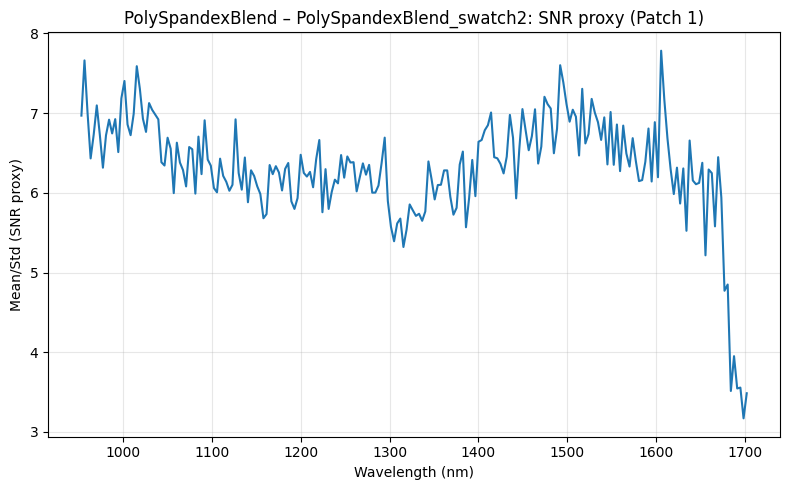

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch2_snr_proxy.png
Saved CSV: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch2_patch_spectra.csv


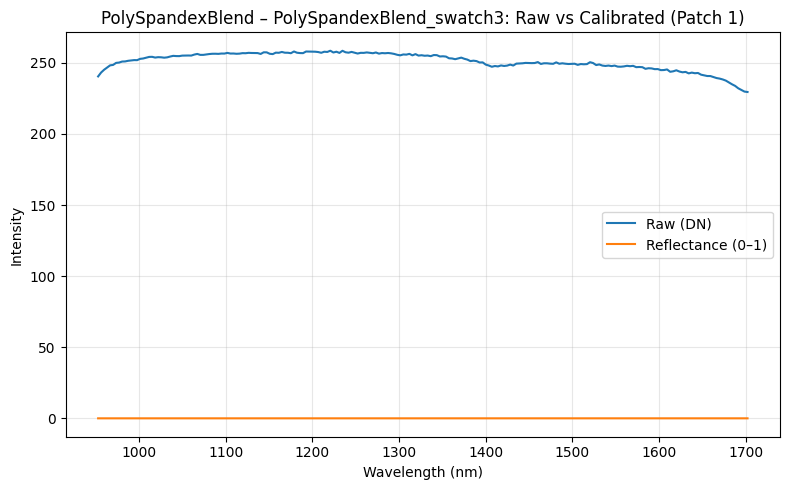

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch3_raw_vs_reflectance.png


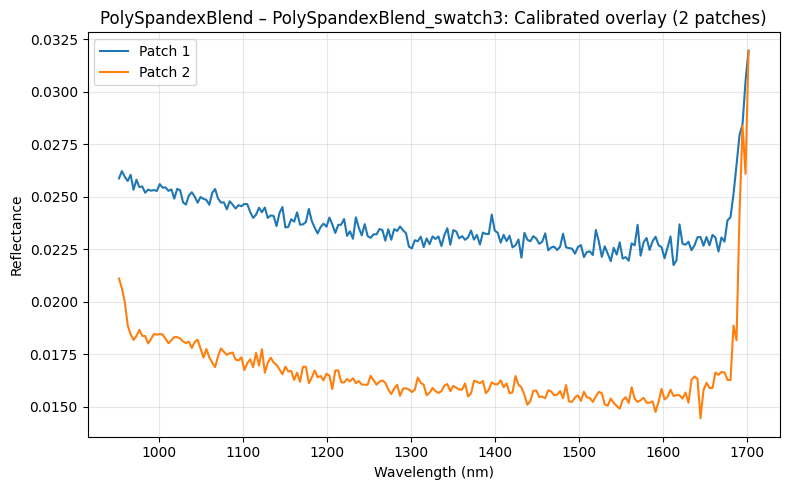

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch3_reflectance_overlay_patches.png


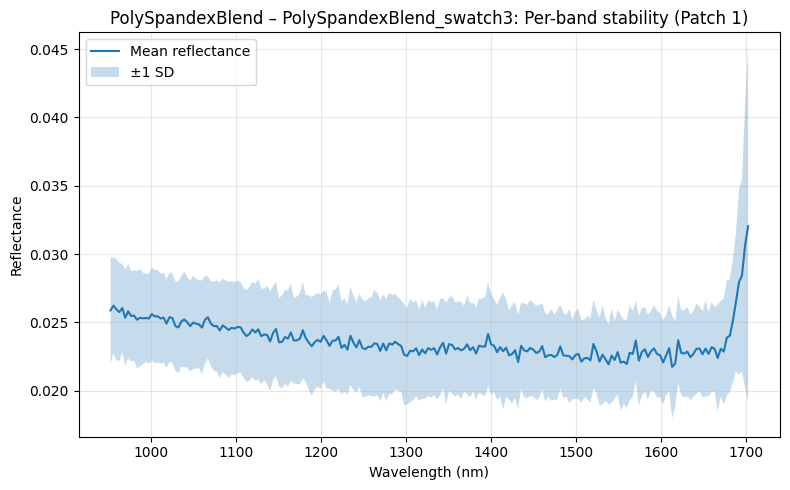

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch3_stability_mean_sd.png


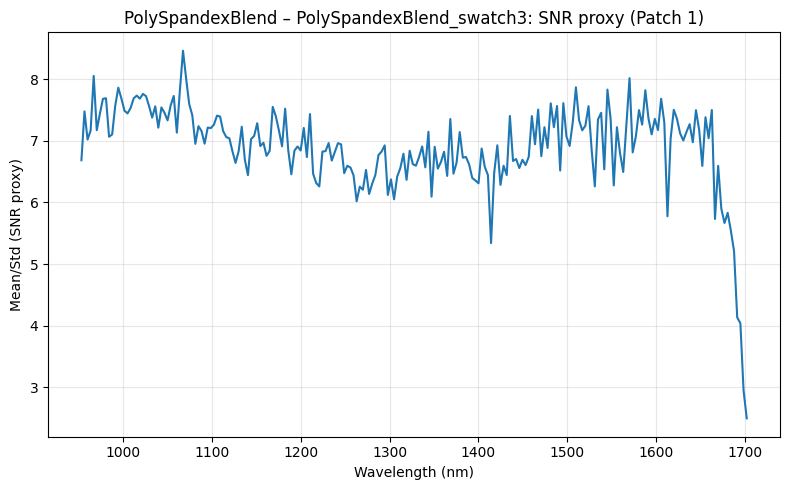

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch3_snr_proxy.png
Saved CSV: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/PolySpandexBlend_swatch3_patch_spectra.csv


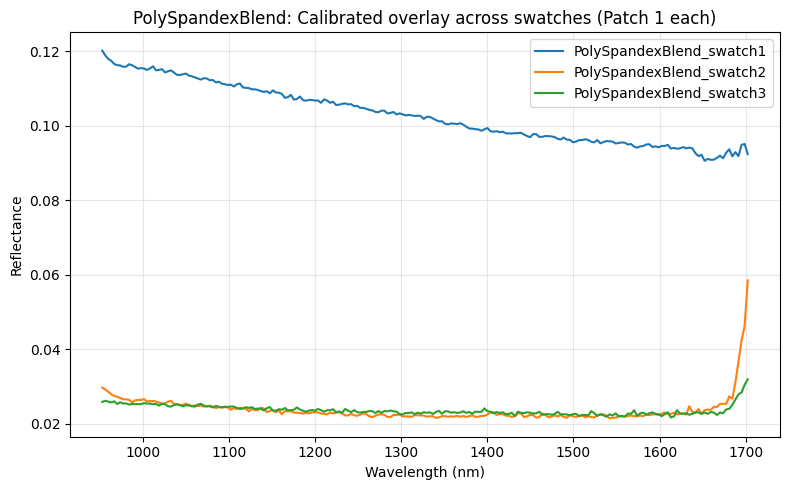

Saved: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/polyspandexblend_overlay_across_swatches.png
Saved CSV: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/polyspandexblend_overlay_across_swatches.csv
Saved QC: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend/polyspandexblend_qc_summary.csv

All done. Outputs in: /content/drive/Shareddrives/Danika-work4/Textile/deeptextile_validationPolySpandexBlend


In [13]:
# =============================
# Colab: Swatch-aware segmentation + calibration + analysis bundle
# =============================
!pip -q install spectral numpy matplotlib pandas scikit-learn

import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral as spy
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['savefig.dpi'] = 300

# ---------- EDIT THESE ----------
CLASS_NAME   = "PolySpandexBlend"   # just for filenames/captions
OUTDIR       = ""  # where to save figures & CSVs

# ENVI HDR paths for this class/file

SAMPLE_HDR   = "/content/sample/Joann_Fab_100Cotton_sample.hdr"
WHITEREF_HDR = "/content/sample/WHITEREF_2024-06-10_12-00-00.hdr"
DARKREF_HDR  = "/content/sample/DARKREF_2024-06-10_12-01-00.hdr"

# Layout hint: are the three swatches arranged top→bottom (along rows) or left→right (along cols)?
# Choose one of: 'row' or 'col'
LAYOUT_AXIS = "row"       # "row" = stacked vertically; "col" = side-by-side

# Number of swatches expected and patches per swatch
N_SWATCHES          = 3
PATCHES_PER_SWATCH  = 2
PATCH_SIZE_RC       = (50, 50)    # (rows, cols) for each patch
RANDOM_SEED         = 42

# Band trimming (often the very first/last few bands are noisy). Set to None to disable.
TRIM_BANDS = (5, -5)

# Numerical stability for calibration
EPS = 1e-6

os.makedirs(OUTDIR, exist_ok=True)
rng = np.random.default_rng(RANDOM_SEED)

# ---------- Helpers ----------
def open_envi(hdr_path):
    img = spy.open_image(hdr_path)
    cube = img.load()
    if cube.ndim != 3:
        raise ValueError(f"Expected 3D cube, got {cube.shape} @ {hdr_path}")
    return img, cube

def wavelengths_from_hdr(img):
    if hasattr(img, 'bands') and hasattr(img.bands, 'centers'):
        try:
            wl = np.array(img.bands.centers, dtype=float)
            return wl
        except Exception:
            pass
    return None

def apply_trim(arr, trim):
    if trim is None:
        return arr
    s, e = trim
    if isinstance(arr, np.ndarray):
        if arr.ndim == 1:
            return arr[s: (None if e == 0 else e)]
        else:
            return arr[..., s: (None if e == 0 else e)]
    return arr

def ref_vector_from_cube(ref_cube):
    # average over rows & cols → (bands,)
    return np.asarray(ref_cube.mean(axis=(0,1)))

def calibrate_spectrum(S_spec, W_vec, D_vec, eps=1e-6):
    R = (S_spec - D_vec) / (W_vec - D_vec + eps)
    return np.clip(R, 0.0, 1.0)

def calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6):
    Wv = W_vec.reshape((1,1,-1))
    Dv = D_vec.reshape((1,1,-1))
    Rc = (S_cube - Dv) / (Wv - Dv + eps)
    return np.clip(Rc, 0.0, 1.0)

def contiguous_segments(labels):
    """Given a 1D sequence of labels, return list of (start, stop, label) for contiguous runs."""
    segs = []
    start = 0
    cur = labels[0]
    for i in range(1, len(labels)):
        if labels[i] != cur:
            segs.append((start, i, cur))
            start = i
            cur = labels[i]
    segs.append((start, len(labels), cur))
    return segs

def kmeans_segment_1d(signal_1d, n_segments=3):
    """Cluster a 1D signal into n clusters (KMeans), then choose the top n contiguous runs by length."""
    X = signal_1d.reshape(-1,1)
    km = KMeans(n_clusters=n_segments, n_init=10, random_state=0)
    lab = km.fit_predict(X)

    # turn clustered row/col labels into contiguous runs
    runs = contiguous_segments(lab)
    # If we get more than n_segments runs, pick the largest n by length
    runs_sorted = sorted(runs, key=lambda t: (t[1]-t[0]), reverse=True)[:n_segments]
    # sort by position (start)
    runs_sorted = sorted(runs_sorted, key=lambda t: t[0])
    return runs_sorted  # list of (start, stop, label)

def choose_random_patch_within_slice(swatch_slice_rc, cube_shape, patch_size_rc, rng):
    r_slice, c_slice = swatch_slice_rc
    r0_min = r_slice.start
    r0_max = r_slice.stop - patch_size_rc[0]
    c0_min = c_slice.start
    c0_max = c_slice.stop - patch_size_rc[1]
    if r0_max <= r0_min or c0_max <= c0_min:
        raise ValueError("Patch size too large for the swatch slice; reduce PATCH_SIZE_RC or adjust segmentation.")
    r0 = rng.integers(r0_min, r0_max+1)
    c0 = rng.integers(c0_min, c0_max+1)
    return (slice(r0, r0+patch_size_rc[0]), slice(c0, c0+patch_size_rc[1]))

def extract_patch_spectrum(cube, patch_slice):
    sub = cube[patch_slice[0], patch_slice[1], :]  # (rows, cols, bands)
    return np.asarray(sub.mean(axis=(0,1)))

def qc_rowcol_means(S_cube, axis='row'):
    if axis == 'row':
        return S_cube.mean(axis=(1,2))  # per-row mean
    else:
        return S_cube.mean(axis=(0,2))  # per-col mean

# ---------- Load data ----------
S_img, S_cube = open_envi(SAMPLE_HDR)
W_img, W_cube = open_envi(WHITEREF_HDR)
D_img, D_cube = open_envi(DARKREF_HDR)

W_vec = ref_vector_from_cube(W_cube)
D_vec = ref_vector_from_cube(D_cube)

# Trim consistently
S_cube = apply_trim(S_cube, TRIM_BANDS)
W_vec  = apply_trim(W_vec,  TRIM_BANDS)
D_vec  = apply_trim(D_vec,  TRIM_BANDS)

wavelengths = wavelengths_from_hdr(S_img)
if wavelengths is not None:
    wavelengths = apply_trim(wavelengths, TRIM_BANDS)

bands = S_cube.shape[2]
rows, cols = S_cube.shape[0], S_cube.shape[1]
x_axis = wavelengths if wavelengths is not None else np.arange(bands)
x_label = "Wavelength (nm)" if wavelengths is not None else "Band index"

print("Sample cube:", S_cube.shape, "| Bands:", bands)

# ---------- Segment into swatches ----------
if LAYOUT_AXIS == "row":
    prof = qc_rowcol_means(S_cube, axis='row')      # (rows,)
    runs = kmeans_segment_1d(prof, n_segments=N_SWATCHES)  # [(r0,r1,label), ...]
    # Build swatch slices (full columns)
    swatch_slices = [(slice(r0, r1), slice(0, cols)) for (r0, r1, _) in runs]
else:
    prof = qc_rowcol_means(S_cube, axis='col')      # (cols,)
    runs = kmeans_segment_1d(prof, n_segments=N_SWATCHES)
    # Build swatch slices (full rows)
    swatch_slices = [(slice(0, rows), slice(c0, c1)) for (c0, c1, _) in runs]

# Save a quick profile plot to show segmentation
plt.figure()
plt.plot(prof)
for (a,b,_) in runs:
    plt.axvspan(a, b, alpha=0.15)
plt.title(f"{CLASS_NAME}: {'Row' if LAYOUT_AXIS=='row' else 'Col'} mean profile with swatch segments")
plt.xlabel("Row index" if LAYOUT_AXIS=='row' else "Col index")
plt.ylabel("Mean intensity (DN)")
plt.tight_layout()
prof_path = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_seg_profile.png")
plt.savefig(prof_path)
plt.show()
print("Saved:", prof_path)

# ---------- Calibrate full cube (for stability plots) ----------
R_cube = calibrate_cube(S_cube, W_vec, D_vec, EPS)

# ---------- Run per-swatch analyses ----------
stats_rows = []
overlay_records = []   # for overlay CSV of one patch per swatch
patch_summaries = []   # per patch spectra CSV (can be large; write one per swatch)

for sidx, sw_slice in enumerate(swatch_slices, start=1):
    sw_name = f"{CLASS_NAME}_swatch{sidx}"
    # pick PATCHES_PER_SWATCH patches
    patches = []
    for p in range(PATCHES_PER_SWATCH):
        patch_slice = choose_random_patch_within_slice(sw_slice, S_cube.shape, PATCH_SIZE_RC, rng)
        patches.append(patch_slice)

    # For the first patch: raw vs calibrated figure
    S_raw_spec = extract_patch_spectrum(S_cube, patches[0])
    R_spec     = calibrate_spectrum(S_raw_spec, W_vec, D_vec, EPS)

    plt.figure()
    plt.plot(x_axis, S_raw_spec, label="Raw (DN)")
    plt.plot(x_axis, R_spec,     label="Reflectance (0–1)")
    plt.xlabel(x_label); plt.ylabel("Intensity")
    plt.title(f"{CLASS_NAME} – {sw_name}: Raw vs Calibrated (Patch 1)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{sw_name}_raw_vs_reflectance.png")
    plt.savefig(pth); plt.show()
    print("Saved:", pth)

    # For overlay: calibrated spectra of all patches in this swatch
    plt.figure()
    for p, ps in enumerate(patches, start=1):
        spec = extract_patch_spectrum(S_cube, ps)
        ref  = calibrate_spectrum(spec, W_vec, D_vec, EPS)
        plt.plot(x_axis, ref, label=f"Patch {p}")
        # collect one representative spectrum per swatch for cross-swatch overlay CSV
        if p == 1:
            overlay_records.append({"class": CLASS_NAME, "swatch": sw_name, "x": x_axis.tolist(), "reflectance": ref.tolist()})
    plt.xlabel(x_label); plt.ylabel("Reflectance")
    plt.title(f"{CLASS_NAME} – {sw_name}: Calibrated overlay ({PATCHES_PER_SWATCH} patches)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{sw_name}_reflectance_overlay_patches.png")
    plt.savefig(pth); plt.show()
    print("Saved:", pth)

    # Stability & SNR in ONE chosen patch (Patch 1)
    r0s, c0s = patches[0]
    R_patch = R_cube[r0s, c0s, :]  # (rows, cols, bands)
    r_mean  = R_patch.mean(axis=(0,1))
    r_std   = R_patch.std(axis=(0,1))
    snr     = np.where(r_std > 0, r_mean / r_std, np.nan)

    # mean±SD
    plt.figure()
    plt.plot(x_axis, r_mean, label="Mean reflectance")
    plt.fill_between(x_axis, r_mean - r_std, r_mean + r_std, alpha=0.25, label="±1 SD")
    plt.xlabel(x_label); plt.ylabel("Reflectance")
    plt.title(f"{CLASS_NAME} – {sw_name}: Per-band stability (Patch 1)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{sw_name}_stability_mean_sd.png")
    plt.savefig(pth); plt.show()
    print("Saved:", pth)

    # SNR proxy
    plt.figure()
    plt.plot(x_axis, snr)
    plt.xlabel(x_label); plt.ylabel("Mean/Std (SNR proxy)")
    plt.title(f"{CLASS_NAME} – {sw_name}: SNR proxy (Patch 1)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{sw_name}_snr_proxy.png")
    plt.savefig(pth); plt.show()
    print("Saved:", pth)

    # QC stats (reflectance distribution summary for Patch 1)
    stats_rows.append({
        "class": CLASS_NAME,
        "swatch": sw_name,
        "bands": int(bands),
        "reflectance_min": float(np.nanmin(r_mean)),
        "reflectance_max": float(np.nanmax(r_mean)),
        "reflectance_mean": float(np.nanmean(r_mean)),
        "reflectance_std": float(np.nanstd(r_mean))
    })

    # Save per-patch calibrated spectra to CSV (for SI)
    patch_df = pd.DataFrame({x_label: x_axis})
    for p, ps in enumerate(patches, start=1):
        spec = extract_patch_spectrum(S_cube, ps)
        ref  = calibrate_spectrum(spec, W_vec, D_vec, EPS)
        patch_df[f"patch{p}_reflectance"] = ref
        # (Optional) also include raw for patch 1
        if p == 1:
            patch_df["patch1_raw_dn"] = spec
    csv_path = os.path.join(OUTDIR, f"{sw_name}_patch_spectra.csv")
    patch_df.to_csv(csv_path, index=False)
    print("Saved CSV:", csv_path)
    patch_summaries.append(csv_path)

# ---------- Cross-swatch overlay figure & CSV ----------
# Overlay one representative calibrated spectrum from each swatch (Patch 1)
plt.figure()
for rec in overlay_records:
    xx = np.array(rec["x"])
    rr = np.array(rec["reflectance"])
    plt.plot(xx, rr, label=rec["swatch"])
plt.xlabel(x_label); plt.ylabel("Reflectance")
plt.title(f"{CLASS_NAME}: Calibrated overlay across swatches (Patch 1 each)")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
pth = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_overlay_across_swatches.png")
plt.savefig(pth); plt.show()
print("Saved:", pth)

# Write overlay CSV (aligned by band index or wavelength)
# (Assumes same band grid across swatches within the same file)
overlay_df = pd.DataFrame({x_label: x_axis})
for rec in overlay_records:
    overlay_df[rec["swatch"]] = np.array(rec["reflectance"])
csv_path = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_overlay_across_swatches.csv")
overlay_df.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)

# ---------- QC summary CSV ----------
qc_df = pd.DataFrame(stats_rows)
qc_csv = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_qc_summary.csv")
qc_df.to_csv(qc_csv, index=False)
print("Saved QC:", qc_csv)

# ---------- Save a small JSON manifest describing what we did ----------
manifest = {
    "class_name": CLASS_NAME,
    "layout_axis": LAYOUT_AXIS,
    "bands": int(bands),
    "trim_bands": TRIM_BANDS,
    "patch_size_rc": PATCH_SIZE_RC,
    "patches_per_swatch": PATCHES_PER_SWATCH,
    "random_seed": RANDOM_SEED,
    "outputs": {
        "profile_plot": prof_path,
        "cross_swatch_overlay_png": pth,
        "cross_swatch_overlay_csv": csv_path,
        "qc_csv": qc_csv,
        "per_swatch_patch_csvs": patch_summaries
    }
}
with open(os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)
print("\nAll done. Outputs in:", OUTDIR)
